In [144]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
%matplotlib inline

##Read in the core parameters taken from Overseer

In [145]:
#ReadData
CoreParams = pd.read_excel('.\CropCoeff.xlsx', sheetname='CoreParams')
#Fix names
CoreParams['Crop'] = [str(CoreParams.ix[X,'Crop']).replace(" (","_") for X in range(CoreParams.index.size)]
CoreParams['Crop'] = [str(CoreParams.ix[X,'Crop']).replace("(","_") for X in range(CoreParams.index.size)]
CoreParams['Crop'] = [str(CoreParams.ix[X,'Crop']).replace(")","") for X in range(CoreParams.index.size)]
CoreParams['Crop'] = [str(CoreParams.ix[X,'Crop']).replace("/","_") for X in range(CoreParams.index.size)]
CoreParams['Crop'] = [str(CoreParams.ix[X,'Crop']).replace(" ","") for X in range(CoreParams.index.size)]
#SetIndex
CoreParams.set_index('Crop', inplace=True,drop=True)
#some useful lists
SCRUMParamList = ['[Root].MaximumRootDepth.Value',
                '[Root].KLModifier.XYPairs.Y' ,
                '[Stover].CoverFunction.Expanding.SigCoverFunction.Xo.Value' ,
                '[Stover].CoverFunction.Expanding.SigCoverFunction.b.Value',
                '[Stover].CoverFunction.Expanding.SigCoverFunction.Ymax.Value' ,
                '[Stover].XoBiomass.Value',
                '[Stover].bBiomass.Value' ,
                '[Product].ExpectedYield.Value',
                '[Root].RootProportion.Value' ,
                '[Product].HarvestIndex.Value' ,
                '[Product].DryMatterContent.Value' ,
                '[Phenology].CanopyExpanding.Target.Value' ,
                '[Phenology].YieldIncreasing.Target.Value',
                '[Phenology].Senescing.Target.Value',
                '[Stover].MaximumNConc.Value',
                '[Stover].MinimumNConc.Value',
                '[Product].MinimumNConc.Value',
                '[Product].MaximumNConc.Value',
                '[Root].MinimumNConc.Value',
                '[Root].MaximumNConc.Value',
                '[Nodule].FixationRate.Value',
                '[Nodule].FixationMetabolicCost.Value']
CropList = CoreParams.index.tolist()
CropList.sort()
SCRUMParamList.sort()

##Set up working dataframes

In [146]:
Step1 = CoreParams.ix[:,~(CoreParams.columns == 'TT_Sen')].copy()
SCRUMParams = Step1.ix[:,~(Step1.columns == 'TT_Mat')].copy()
#SCRUMParams['[Nodule].NFixationOption'] = [str(SCRUMParams.ix[X,'[Nodule].NFixationOption']).replace("'","") for X in range(SCRUMParams.index.size)]
AncillaryParams = pd.DataFrame(index=CoreParams.index)

##Do some simple calculations first

In [147]:
#Calculate the inflection point ot the DM sigmoid as 50% of the crops duration
HalfMat = CoreParams.TT_Mat*0.5
SCRUMParams['[Stover].XoBiomass.Value'] = HalfMat.round(decimals=0)
#The curvature parameter of the DM sigmoid is 1/5 of the inflection point
FifthMat = SCRUMParams['[Stover].XoBiomass.Value']*0.2
SCRUMParams['[Stover].bBiomass.Value'] = FifthMat.round(decimals=0)
#The duration of the Phase from the start to end of senescence is the total tt accumulated to mat less that to sen
SCRUMParams['[Phenology].Senescing.Target.Value'] = CoreParams['TT_Mat'] - CoreParams['TT_Sen']                                                       
#Minimum N conc of stover is the same as maximum
SCRUMParams['[Stover].MinimumNConc.Value'] = SCRUMParams['[Stover].MaximumNConc.Value'] 
#Nodule metabolic fixiation cost is zero
SCRUMParams['[Nodule].FixationMetabolicCost.Value'] = 0

##Then calculate some additional values that will be needed for other parameters

In [148]:
#The total amount of biomass if the yield of the crop reached the expected value
AncillaryParams['YMax'] = (SCRUMParams['[Product].ExpectedYield.Value']* \
                          SCRUMParams['[Product].DryMatterContent.Value'])/  \
                          (1-SCRUMParams['[Root].RootProportion.Value'])/ \
                          SCRUMParams['[Product].HarvestIndex.Value']

#The amount of DM at maturity will be slightly less than YMax because the sigmoid won't have reached its asymtote by then
AncillaryParams['DMatMatur'] = AncillaryParams['YMax'] * \
                               1/(1+np.exp(-(CoreParams['TT_Mat']-\
                                             SCRUMParams['[Stover].XoBiomass.Value'])/\
                                           SCRUMParams['[Stover].bBiomass.Value']))
#Root DM at this point is a function of root Proportion
AncillaryParams['RootDM'] =  AncillaryParams['DMatMatur'] * SCRUMParams['[Root].RootProportion.Value']
#Product DM at this point is a function of harvest index
AncillaryParams['ProductDM'] = (AncillaryParams['DMatMatur'] - \
                                AncillaryParams['RootDM']) * \
                                SCRUMParams['[Product].HarvestIndex.Value']
#Stover DM is the residual
AncillaryParams['StoverDM'] = AncillaryParams['DMatMatur'] - \
                              AncillaryParams['RootDM'] - \
                              AncillaryParams['ProductDM']
#We are assuming 20% of the stover biomass is produced during the reproductive phase
AncillaryParams['StoverInRepro'] = AncillaryParams['StoverDM'] * 0.2
#So the amount of biomass at the start of the reproductive phase will be 80% of the total stover 
#adjusted to account for root proportion
AncillaryParams['DMatStartRepro'] = (AncillaryParams['StoverDM'] - \
                                    AncillaryParams['StoverInRepro']) * \
                                    (1+SCRUMParams['[Root].RootProportion.Value'])
#Then we can invert the DM sigmoid to work out how much Tt has passed when this amout of biomass has accumulated
AncillaryParams['TtatStartRepro'] = np.log(1/(AncillaryParams['DMatStartRepro']/\
                                          AncillaryParams['DMatMatur'])-1) * \
                                        SCRUMParams['[Stover].bBiomass.Value'] * -1 + \
                                        SCRUMParams['[Stover].XoBiomass.Value']

##Calculate remaining Phenology parameters

In [149]:
#The tt duration of the canopy expanding (vegetative) phase
SCRUMParams['[Phenology].CanopyExpanding.Target.Value'] = AncillaryParams['TtatStartRepro'].round(decimals=0)
#The tt duration of the yield increasing phase (growing reproductive DM and canopy not senescing)
#is what is left of thermal time to start of senescence after the vegetative phase is taken out
tt_yield = CoreParams['TT_Sen'] - SCRUMParams['[Phenology].CanopyExpanding.Target.Value']
SCRUMParams['[Phenology].YieldIncreasing.Target.Value'] = tt_yield.round(decimals=0)

##Generate arays of kl modifier values, adjusted for root depth

In [150]:
def StringMaker(DepthInts,RootDepth):
    YArray = ''
    for Depth in DepthInts:
        if Depth > 0:
            YArray += ','
        if Depth < 305:
            klFact = 1
        elif Depth < RootDepth:
            klFact = 1*np.exp(-.002*(1500/(RootDepth-300)*(Depth-300)))
        else:
            klFact = 0
        klFact = np.round(klFact,3)
        YArray += str(klFact)
    return YArray

DepthInts = range(0,1499,50)
SCRUMParams['[Root].KLModifier.XYPairs.Y'] = \
    [StringMaker(DepthInts,SCRUMParams.ix[X,'[Root].MaximumRootDepth.Value']) \
     for X in range(SCRUMParams.index.size)]

##Build XML and write to file

In [151]:
Crops = ET.Element('Crops')
for Crop in CropList:
    CropElement = ET.SubElement(Crops, 'Cultivar')
    NameTag = ET.SubElement(CropElement, 'Name')
    NameTag.text = str(Crop)
    for Param in SCRUMParamList:
        Command = ET.SubElement(CropElement,'Command')
        Command.text = str(Param + ' = ' + str(SCRUMParams.ix[Crop,Param]))

ET.ElementTree(Crops).write('.\Crop.xml')

##Graph kl patterns

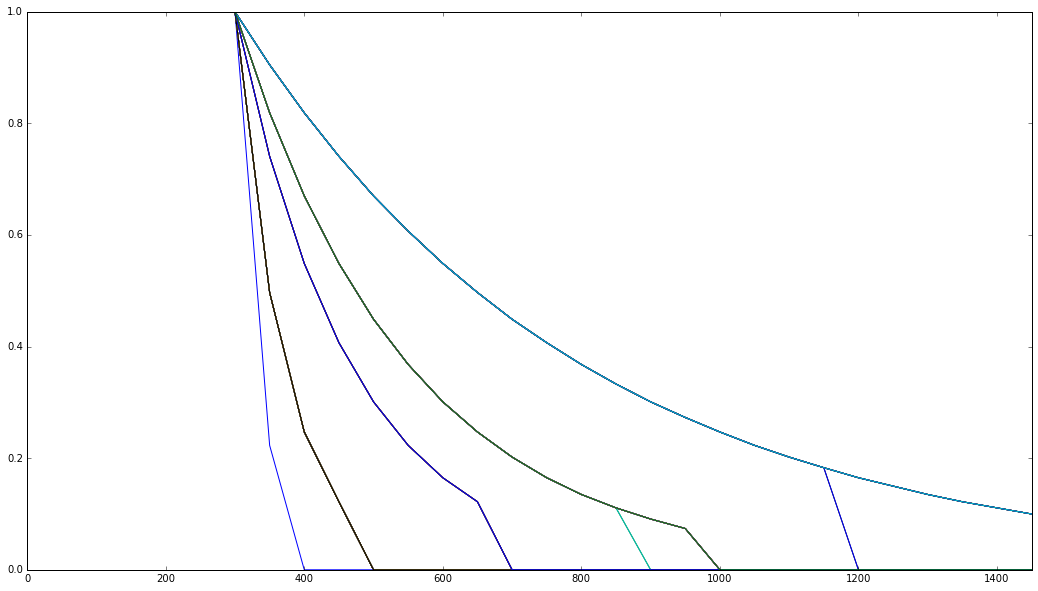

In [152]:
def DoubleMaker(Crop, DepthInts,RootDepth):
    YArray = ''
    for Depth in DepthInts:
        if Depth < 305:
            klFact = 1
        elif Depth < RootDepth:
            klFact = 1*np.exp(-.002*(1500/(RootDepth-300)*(Depth-300)))
        else:
            klFact = 0
        klFact = np.round(klFact,3)
        KLMods.ix[Crop,Depth] = klFact
    return YArray

KLMods = pd.DataFrame(index = SCRUMParams.index, columns = DepthInts)

for Crop in CropList:
    DoubleMaker(Crop, DepthInts, SCRUMParams.ix[Crop,'[Root].MaximumRootDepth.Value'])
    
KLMods.transpose().plot(legend = False, figsize = (18,10))

In [153]:
SCRUMParams.ix[:,'[Root].KLModifier.XYPairs.Y']

Crop
Barley_Spring                1,1,1,1,1,1,1,0.807,0.651,0.526,0.424,0.343,0....
Maize_Short                  1,1,1,1,1,1,1,0.882,0.779,0.687,0.607,0.535,0....
Maize_Med                    1,1,1,1,1,1,1,0.882,0.779,0.687,0.607,0.535,0....
Maize_Long                   1,1,1,1,1,1,1,0.882,0.779,0.687,0.607,0.535,0....
Oats_Spring                  1,1,1,1,1,1,1,0.807,0.651,0.526,0.424,0.343,0....
Oats_Autumn                  1,1,1,1,1,1,1,0.882,0.779,0.687,0.607,0.535,0....
Wheat_Spring                 1,1,1,1,1,1,1,0.807,0.651,0.526,0.424,0.343,0....
Wheat_Autumn                 1,1,1,1,1,1,1,0.882,0.779,0.687,0.607,0.535,0....
Broccoli_winter_spring       1,1,1,1,1,1,1,0.472,0.223,0.105,0,0,0,0,0,0,0,...
Broccoli_summer              1,1,1,1,1,1,1,0.472,0.223,0.105,0,0,0,0,0,0,0,...
BrusselSprouts               1,1,1,1,1,1,1,0.472,0.223,0.105,0,0,0,0,0,0,0,...
Cabbage_winter_spring        1,1,1,1,1,1,1,0.472,0.223,0.105,0,0,0,0,0,0,0,...
Cabbage_summer               1,1,1,1,1,1,1,0.47

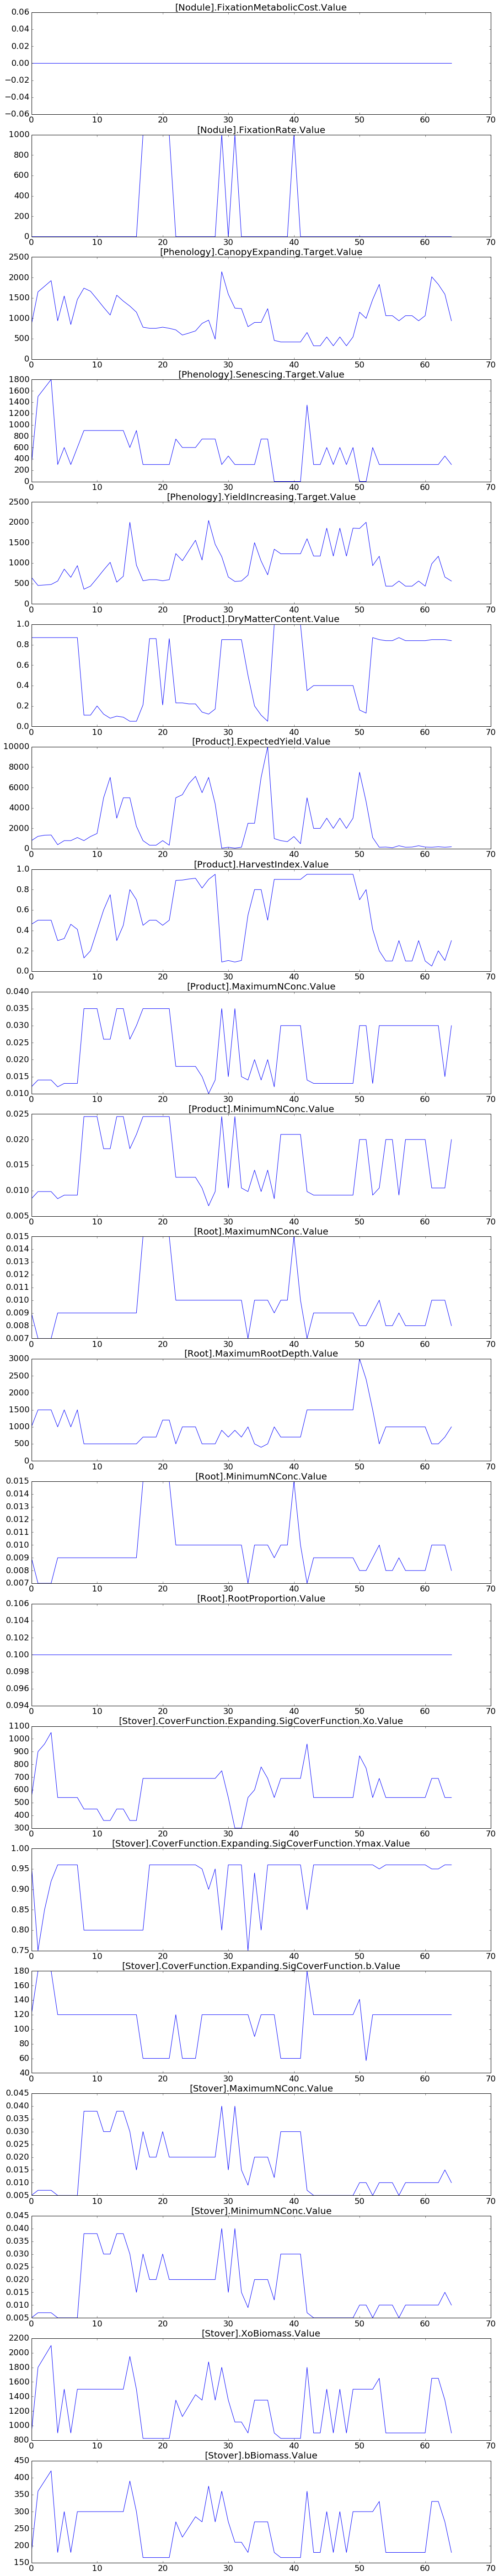

In [154]:
SCRUMParamList.remove('[Root].KLModifier.XYPairs.Y')
Graph = plt.figure(figsize=(18,100))
Pos=1
for var in SCRUMParamList:
    fig = Graph.add_subplot(21,1,Pos)
    plt.plot(range(SCRUMParams.index.size),SCRUMParams.ix[:,var])
    plt.title(var,fontsize=20)
    plt.tick_params(labelsize=18)
    Pos +=1